Option Price: 9.207589968472393
Computation Time: 0.015871524810791016 seconds
Black-Scholes Price: 8.102643534463212


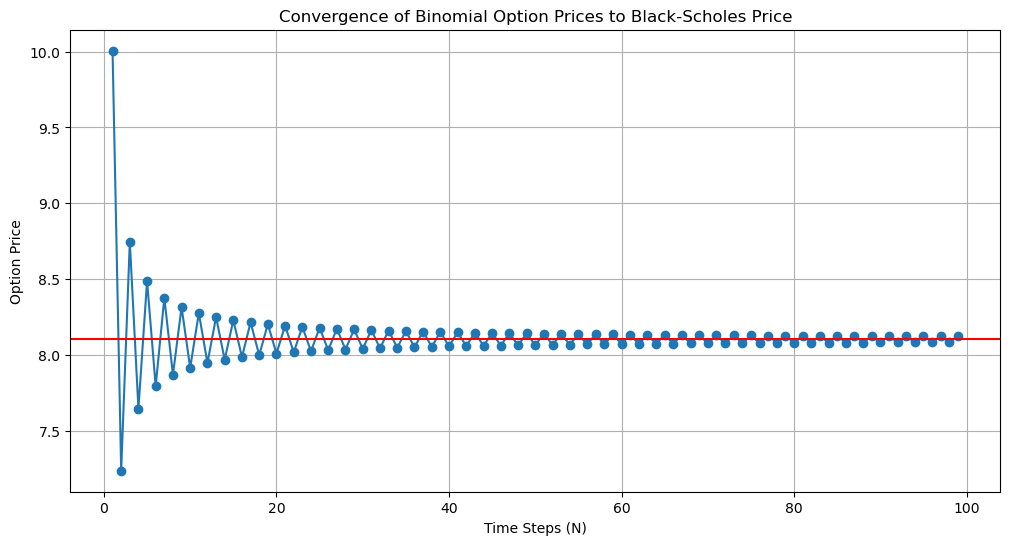

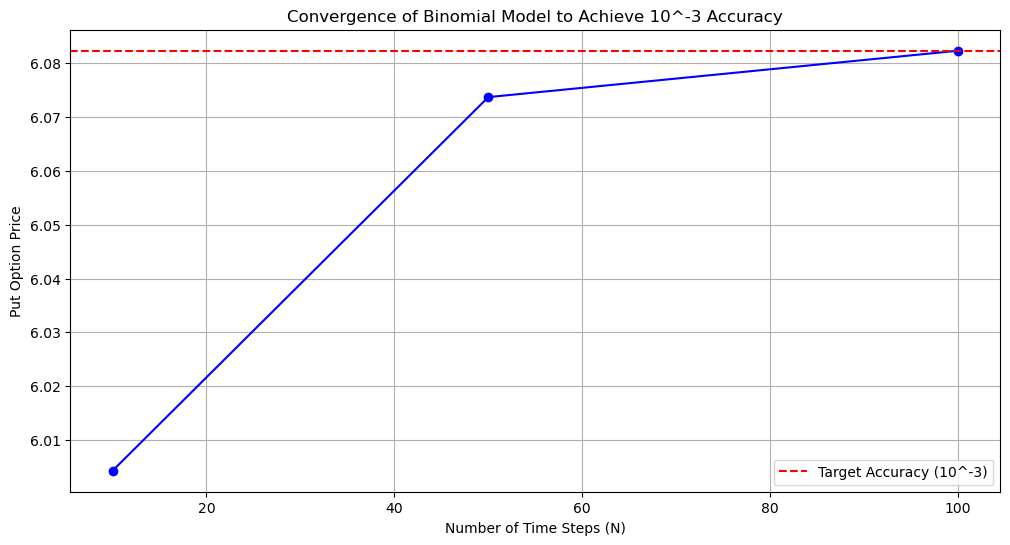

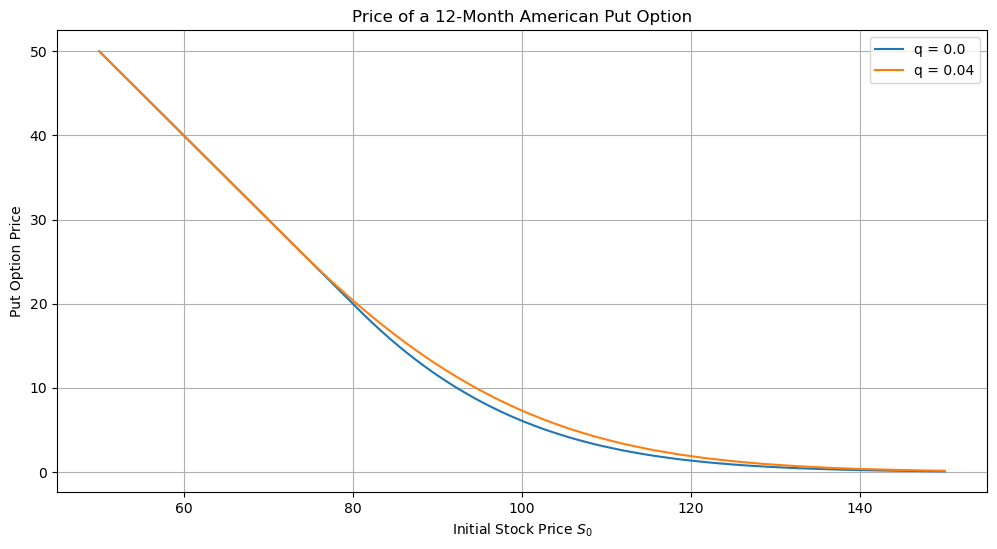

        q=0.0     q=0.04
0   91.182365  88.777555
1   88.777555  85.370741
2   87.274549  83.066132
3   86.072144  81.362725
4   85.270541  79.959920
5   84.468938  78.857715
6   83.867735  77.855711
7   83.266533  77.054108
8   82.765531  76.252505
9   82.364729  75.551102
10  81.963928  74.949900
11  81.563126  74.348697


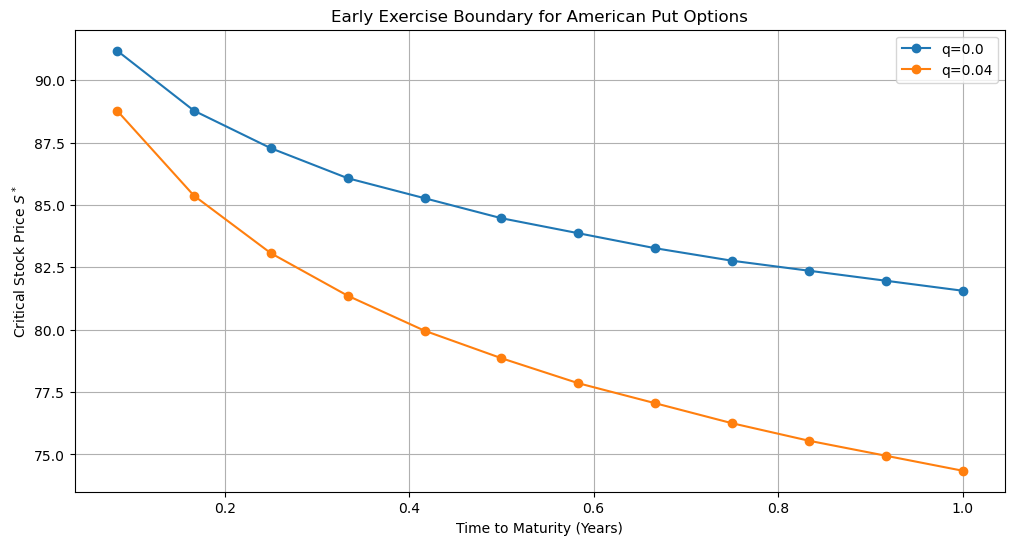

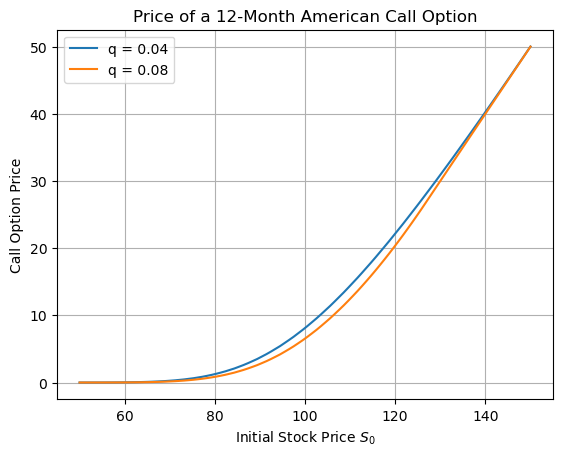

              q=0.04      q=0.08
0.083333  125.060120  110.621242
0.166667  128.697395  113.927856
0.250000  132.224449  116.242485
0.333333  135.310621  118.006012
0.416667  138.286573  119.438878
0.500000  140.711423  120.651303
0.583333  143.026052  121.753507
0.666667  145.120240  122.635271
0.750000  146.883768  123.406814
0.833333  148.647295  124.178357
0.916667  150.300601  124.839679
1.000000  151.843687  125.501002


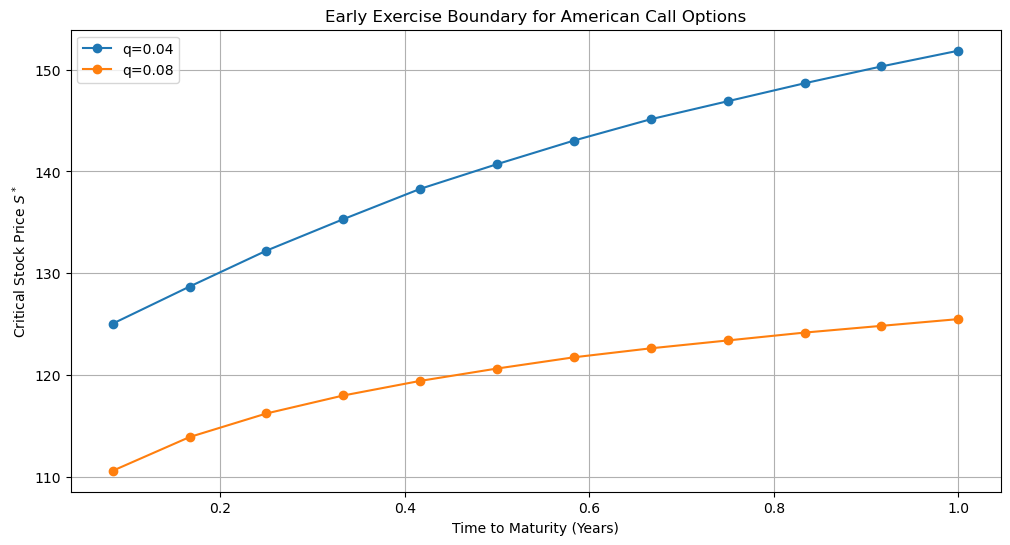

In [79]:
import pandas as pd
import numpy as np
import time
from scipy.stats import norm
import matplotlib.pyplot as plt

# Part 1, CRR Binomial Model (European and American puts and calls on stock with continious dividend yield)
def Binomial(Option, K, T, S0, sigma, r, q, N, Exercise):
    
    # Starts timer for computation
    start = time.time()
    
    # Total time for each step
    delta_time = T / N

    # Up & Down State
    up_state = np.exp(sigma * (np.sqrt(delta_time)))
    down_state = np.exp(-sigma * (np.sqrt(delta_time)))

    # P-star
    p = (np.exp((r - q) * delta_time) - down_state) / (up_state - down_state)

    # Creating a vector for stock prices starting from maturity
    stock_price = np.zeros(N + 1)
    
    # Calculates stock price at node (N, J)
    for j in range(N + 1):
        stock_price[j] = (up_state ** j) * (down_state ** (N - j)) * S0

    # Option Value at maturity
    if Option == 'C':
        option_price = np.maximum(0, stock_price - K)
    elif Option == 'P':
        option_price = np.maximum(0, K - stock_price)

    # Backward Induction
    for i in range(N - 1, -1, -1): 
        for j in range(i + 1):
            stock_price[j] = S0 * (up_state ** j) * (down_state ** (i - j)) # Updates stock prices
            option_price[j] = np.exp(-r * delta_time) * (p * option_price[j + 1] + (1 - p) * option_price[j]) # Discounts option prices

            # Early exercise for American Options
            if Exercise == 'A':  
                if Option == 'C':
                    option_price[j] = np.maximum(option_price[j], stock_price[j] - K)
                elif Option == 'P':
                    option_price[j] = np.maximum(option_price[j], K - stock_price[j])

    # Calculate total computation time
    end = time.time()
    computation_time = end - start
    
    return option_price[0], computation_time

# Test the function
Option = 'C'
K = 100
T = 1
S0 = 100
sigma = 0.2
r = 0.05
q = 0.02
N = 100
Exercise = 'E'      

option_price, computation_time = Binomial(Option, K, T, S0, sigma, r, q, N, Exercise)

print(f"Option Price: {option_price}")
print(f"Computation Time: {computation_time} seconds")

def black_scholes(S, K, T, r, q, sigma, Option):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if Option == 'C':
        option_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif Option == 'P':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    
    return option_price

# Parameters for the European call option
S = 100
K = 100
T = 1  # 1 year
r = 0.05
q = 0.04
sigma = 0.2
Option = 'C'  # Call option
Exercise = 'E'  

black_scholes_price = black_scholes(S, K, T, r, q, sigma, Option)
print(f"Black-Scholes Price: {black_scholes_price}")

N_values = range(1,100)
binomial_prices = [Binomial(Option, K, T, S, sigma, r, q, N, Exercise)[0] for N in N_values]

plt.figure(figsize=(12, 6))
plt.plot(N_values, binomial_prices, marker='o', label='Binomial Prices')
plt.axhline(y=black_scholes_price, linestyle='-', color = 'red', label='Black-Scholes Price')
plt.xlabel('Time Steps (N)')
plt.ylabel('Option Price')
plt.title('Convergence of Binomial Option Prices to Black-Scholes Price')
plt.grid(True)
plt.show()

accuracies = []
time_steps = [10, 50, 100]
target_accuracy = 1e-3

for N in time_steps:
    put_price, _ = Binomial('P', K, 1, 100, sigma, r, 0, N, 'A')
    accuracies.append(put_price)

plt.figure(figsize=(12, 6))
plt.plot(time_steps, accuracies, marker='o', linestyle='-', color='b')
plt.axhline(y=accuracies[-1], color='r', linestyle='--', label='Target Accuracy (10^-3)')
plt.xlabel('Number of Time Steps (N)')
plt.ylabel('Put Option Price')
plt.title('Convergence of Binomial Model to Achieve 10^-3 Accuracy')
plt.grid(True)
plt.legend()
plt.show()

# Define parameters
S_values = np.linspace(50, 150, 100)
q_puts = [0.0, 0.04]
put_prices = {q: [] for q in q_puts}
for q in q_puts:
    for S0 in S_values:
        put_price, _ = Binomial("P", 100, 1, S0, 0.2, 0.05, q, 200, "A")
        put_prices[q].append(put_price)

plt.figure(figsize=(12, 6))
for q in q_puts:
    plt.plot(S_values, put_prices[q], label=f'q = {q}')
plt.xlabel('Initial Stock Price $S_0$')
plt.ylabel('Put Option Price')
plt.title('Price of a 12-Month American Put Option')
plt.legend()
plt.grid(True)
plt.show()

def early_puts(N, K, sigma, r, q, S, T):
    s_star = []
    for j in range(len(T)):
        for i in reversed(range(len(S))):
            intrinsic_value_n = max((K - S[i]), 0)
            p_n, _ = Binomial("P", K, T[j], S[i], sigma, r, q, N, 'A')
            difn = abs(intrinsic_value_n - p_n)
            if difn < 0.005:
                st = i
                for k in reversed(range(st)):
                    p, _ = Binomial("P", K, T[j], S[k], sigma, r, q, N, 'A')
                    intrinsic_value = max((K - S[k]), 0)
                    dif = abs(intrinsic_value - p)
                    if dif < 0.005:
                        s_star.append(S[k])
                        break
                break
    
    return s_star

# Parameters
K = 100
sigma = 0.2
r = 0.05
N = 100  # Number of time steps
S = np.linspace(50, 100, 500)  # Stock price range
T = np.linspace(1/12, 1, 12)  # Maturities from 1/12 to 1 year
q_values = [0.0, 0.04]  # Dividend yield values

results = pd.DataFrame()

for q in q_values:
    s_star = early_puts(N, K, sigma, r, q, S, T)
    results[f'q={q}'] = s_star

print(results)

plt.figure(figsize=(12, 6))
for q in q_values:
    plt.plot(T, results[f'q={q}'], marker='o', linestyle='-', label=f'q={q}')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Critical Stock Price $S^*$')
plt.title('Early Exercise Boundary for American Put Options')
plt.legend()
plt.grid(True)
plt.show()

# Define parameters
S_values = np.linspace(50, 150, 100)  # Example range for S0
q_calls = [0.04, 0.08]  # Different dividend yields
call_prices = {q: [] for q in q_calls}

for q in q_calls:
    for S0 in S_values:
        call_price, _ = Binomial("C", 100, 1, S0, 0.2, 0.05, q, 200, "A")
        call_prices[q].append(call_price)
    plt.plot(S_values, call_prices[q], label=f'q = {q}')

# Plotting the results
plt.xlabel('Initial Stock Price $S_0$')
plt.ylabel('Call Option Price')
plt.title('Price of a 12-Month American Call Option')
plt.legend()
plt.grid(True)
plt.show()

def count_call_s(q, N, S, T, K=100, sigma=0.2, r=0.05, tol=0.005):
    s_star = []

    for j in range(len(T)):
        for i in range(len(S)):
            intrinsic_value_tmp = max((S[i] - K), 0)
            p_n, _ = Binomial("C", K, T[j], S[i], sigma, r, q, N, 'A')
            if isinstance(p_n, (list, np.ndarray)):
                p_n = np.array(p_n).item()
            difn = abs(intrinsic_value_tmp - p_n)
            if difn < tol:
                st = i
                for k in range(st, len(S)):
                    p, _ = Binomial("C", K, T[j], S[k], sigma, r, q, N, 'A')
                    if isinstance(p, (list, np.ndarray)):
                        p = np.array(p).item()  # Convert to scalar
                    intrinsic_value = max((S[k] - K), 0)
                    dif = abs(intrinsic_value - p)
                    if dif < tol:
                        s_star.append(S[k])
                        break
                break

    return s_star

K = 100
sigma = 0.2
r = 0.05
N = 100  # Number of time steps
S = np.linspace(105, 160, 500)  # Stock price range adjusted for calls
T = np.linspace(1/12, 1, 12)  # Maturities from 1/12 to 1 year
q_values = [0.04, 0.08]  # Dividend yield values

results = pd.DataFrame(index=T)

for q in q_values:
    s_star = count_call_s(q, N, S, T)
    results[f'q={q}'] = s_star

print(results)

plt.figure(figsize=(12, 6))
for q in q_values:
    plt.plot(results.index, results[f'q={q}'], marker='o', linestyle='-', label=f'q={q}')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Critical Stock Price $S^*$')
plt.title('Early Exercise Boundary for American Call Options')
plt.legend()
plt.grid(True)
plt.show()